# Train RetinaNet model on CMCT-HEAEL data set

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.sampling import get_slides
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet

path = Path('databases/')

database = Database()
database.open(str(path/'MITOS_WSI_CCMCT_HEAEL.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

In [2]:
getslides = """SELECT filename FROM Slides"""
all_slides = database.execute(getslides).fetchall()


Convert database into in-memory object

In [3]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database)
            

Loading slides .. : 100%|██████████| 32/32 [00:11<00:00,  3.49it/s]


In [4]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [5]:
bs = 16
train_images = 5000
val_images = 5000
size=256

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

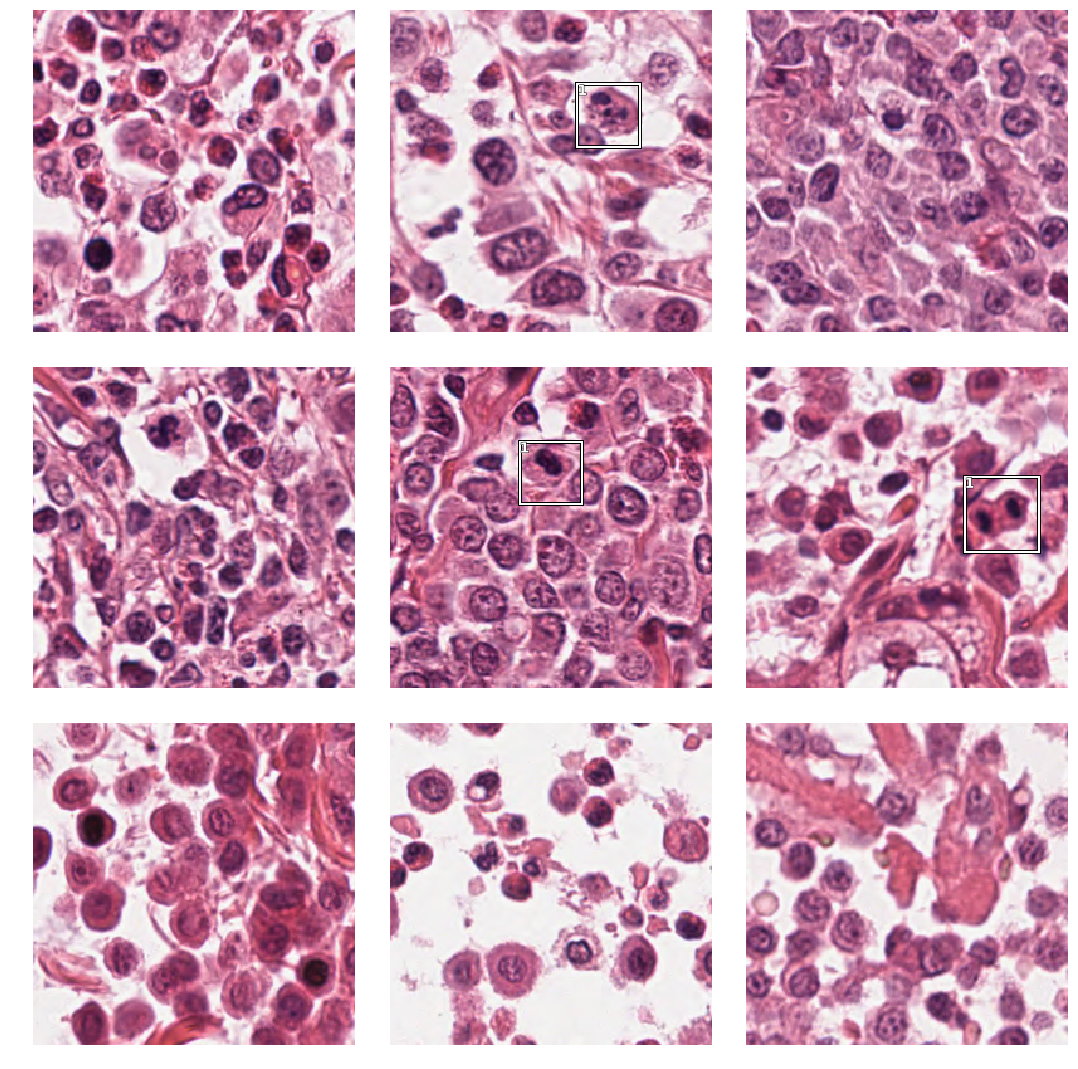

In [8]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

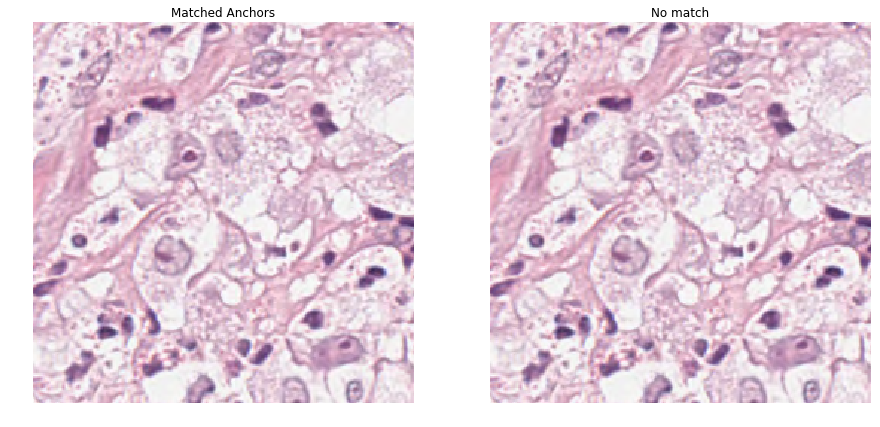

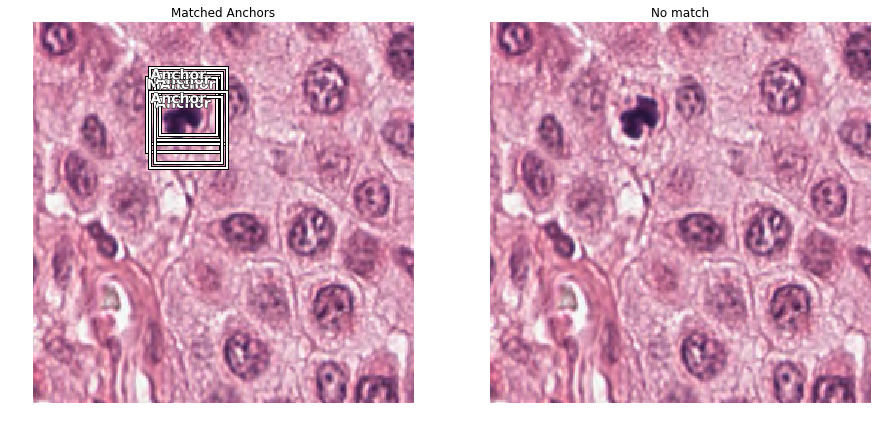

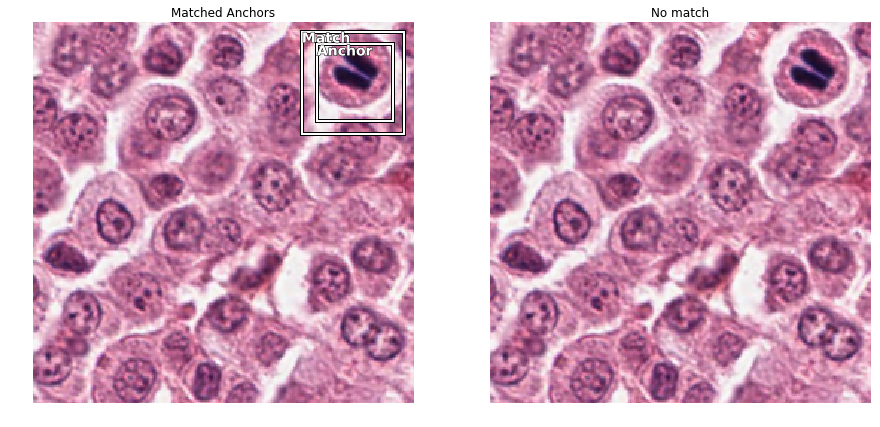

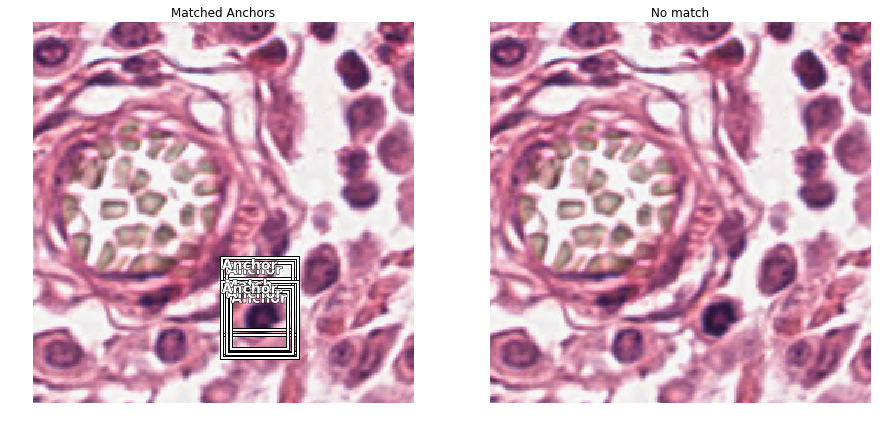

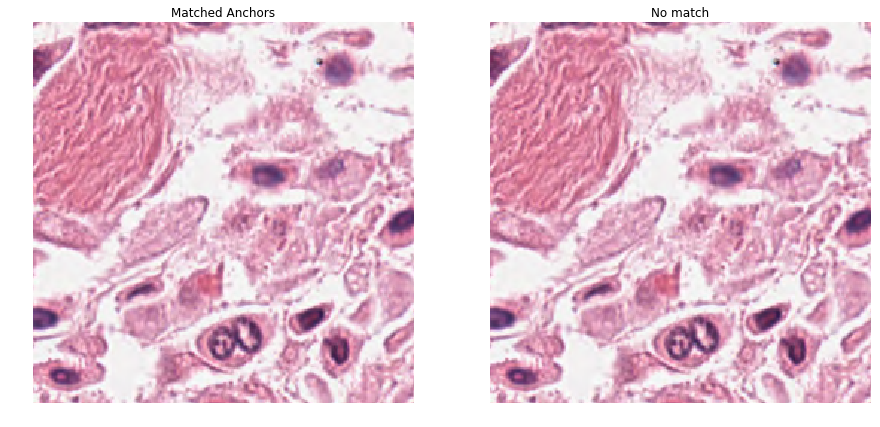

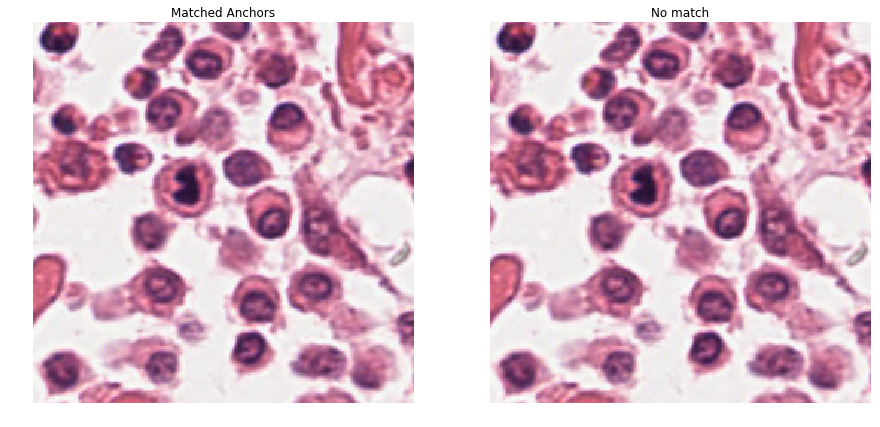

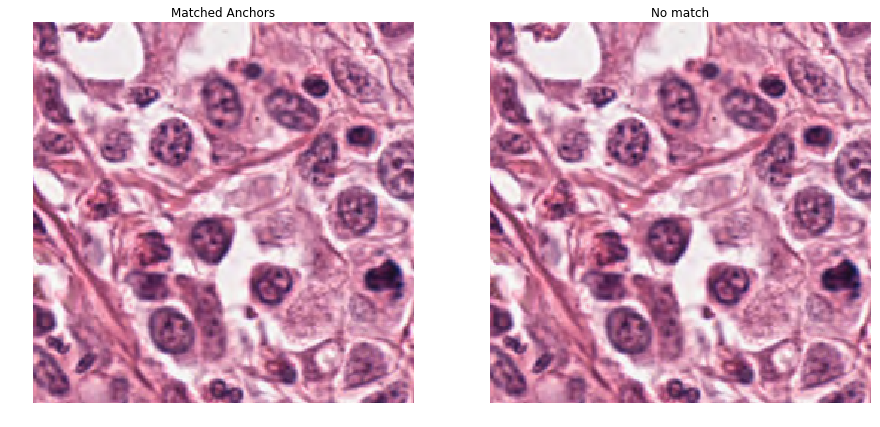

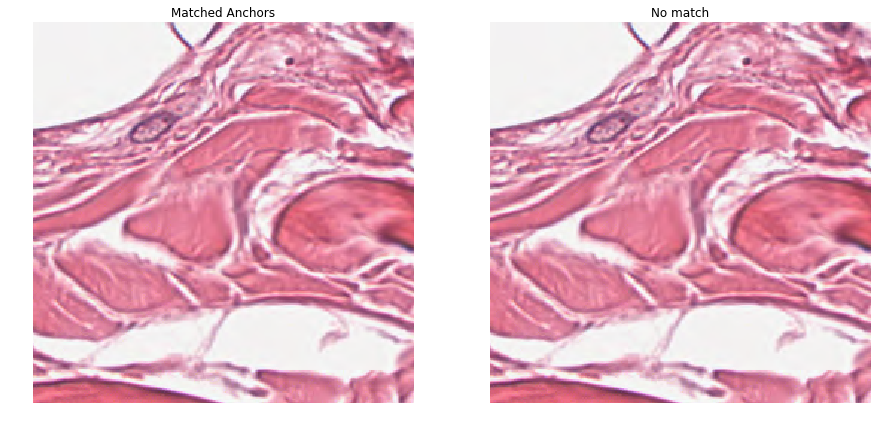

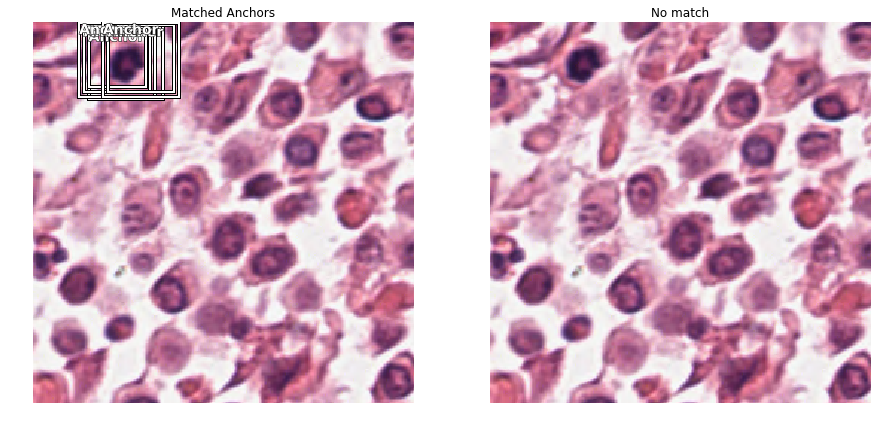

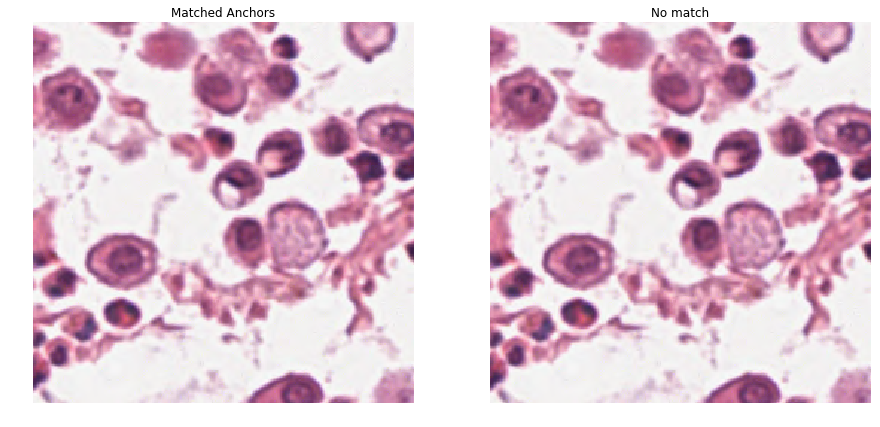

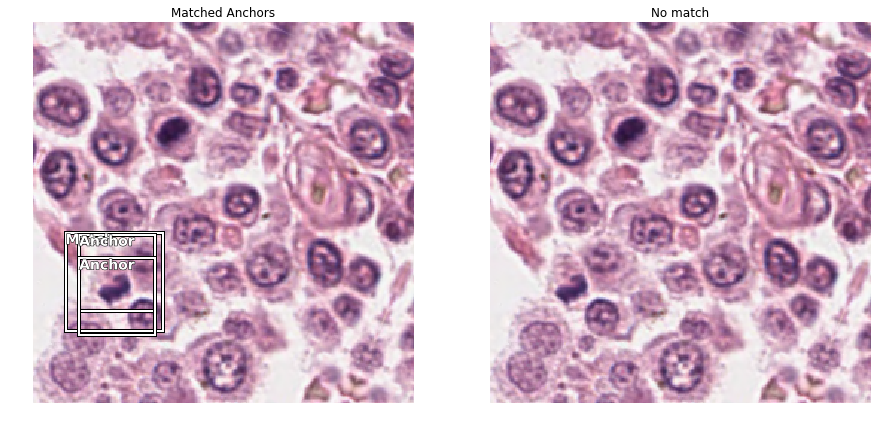

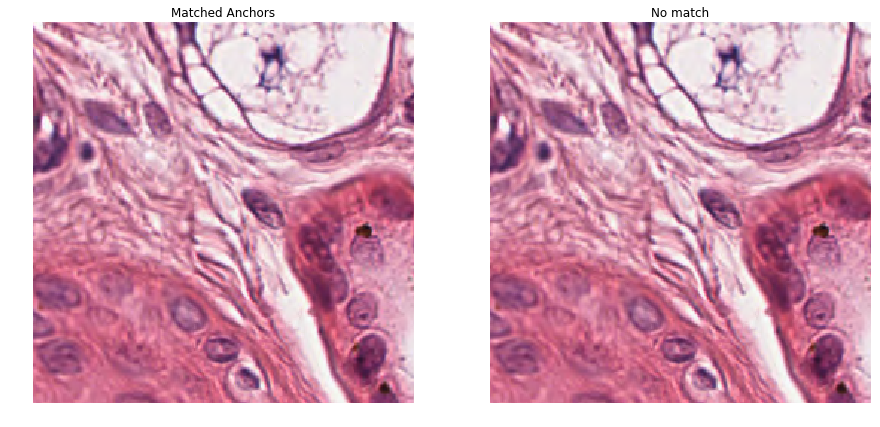

In [9]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])
not_found = show_anchors_on_images(data, anchors)

In [10]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [11]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [12]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


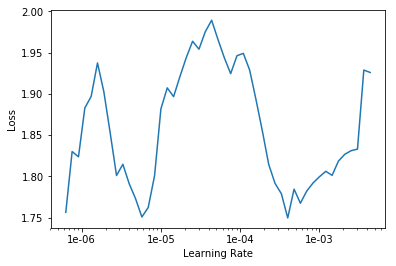

In [13]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1803/1803 [00:00<00:00, 5450.42it/s]


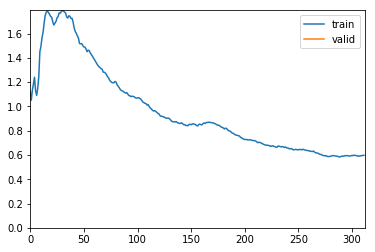

In [14]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 1877/1877 [00:00<00:00, 5463.89it/s]


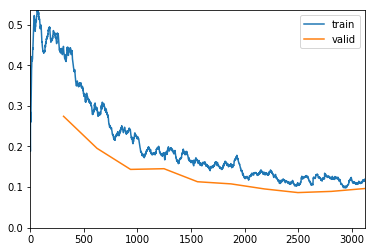

GT: 100%|██████████| 1940/1940 [00:00<00:00, 5307.52it/s]


In [15]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 1956/1956 [00:00<00:00, 5070.95it/s]


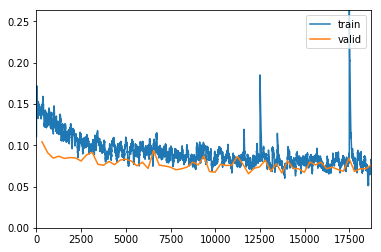

Better model found at epoch 0 with pascal_voc_metric value: 0.7756160252779316.


GT: 100%|██████████| 1909/1909 [00:00<00:00, 5235.17it/s]


Better model found at epoch 1 with pascal_voc_metric value: 0.7904841716806899.


GT: 100%|██████████| 1948/1948 [00:00<00:00, 5117.35it/s]


Better model found at epoch 3 with pascal_voc_metric value: 0.794316682469966.


GT: 100%|██████████| 2008/2008 [00:00<00:00, 5335.52it/s]


Better model found at epoch 4 with pascal_voc_metric value: 0.8116394535562291.


GT: 100%|██████████| 1948/1948 [00:00<00:00, 4880.54it/s]


Better model found at epoch 5 with pascal_voc_metric value: 0.8234515244044562.


GT: 100%|██████████| 1930/1930 [00:00<00:00, 5792.67it/s]


Better model found at epoch 9 with pascal_voc_metric value: 0.8297332667126062.


GT: 100%|██████████| 1976/1976 [00:00<00:00, 4831.83it/s]


Better model found at epoch 13 with pascal_voc_metric value: 0.8432861777650238.


GT: 100%|██████████| 1892/1892 [00:00<00:00, 5658.28it/s]


Better model found at epoch 16 with pascal_voc_metric value: 0.8551445307451688.


GT: 100%|██████████| 1892/1892 [00:00<00:00, 5832.01it/s]


Better model found at epoch 18 with pascal_voc_metric value: 0.866635233382774.


GT: 100%|██████████| 1927/1927 [00:00<00:00, 5834.20it/s]


Better model found at epoch 34 with pascal_voc_metric value: 0.8706831978316885.


GT: 100%|██████████| 1960/1960 [00:00<00:00, 5229.77it/s]


Better model found at epoch 46 with pascal_voc_metric value: 0.874450756495079.


GT: 100%|██████████| 1949/1949 [00:00<00:00, 5692.05it/s]


In [16]:
learn.unfreeze()
lr=1e-4

learn.fit(60, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

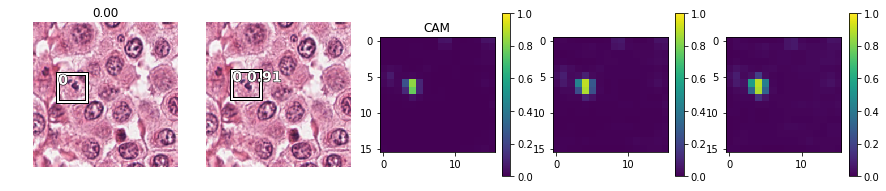

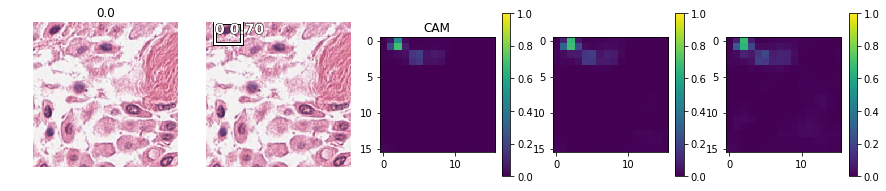

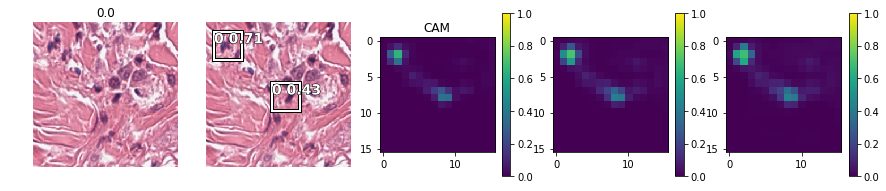

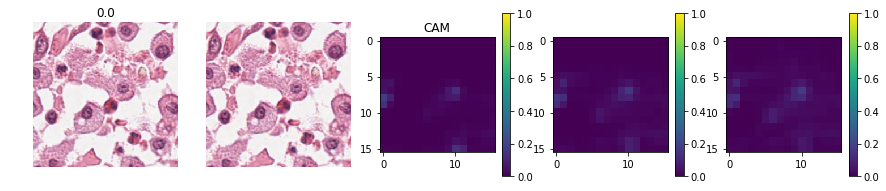

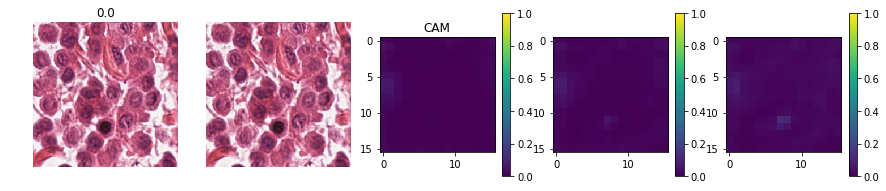

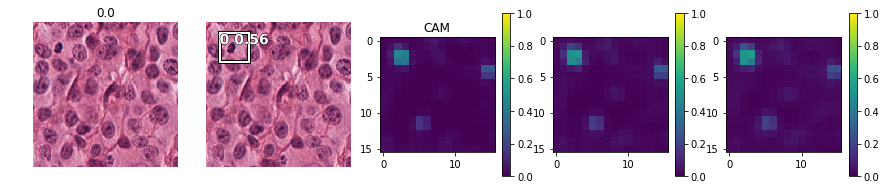

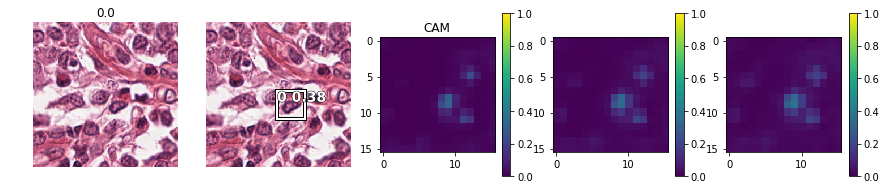

In [17]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [18]:
learn.export("RetinaNet-HEAEL-export.pth")